# ARIMA in Python End to End Stock Price Prediction

Kaggle: https://www.kaggle.com/datasets/rohanrao/nifty50-stock-market-data
<br>
HCLTECH.csv - was downloaded and put in ../data/data_ts/nifty_50_stock/ folder

ARIMA - Auto Regression Integrated Moving Average

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/data_ts/nifty_50_stock/HCLTECH.csv')

In [3]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-11,HCLTECH,EQ,580.00,1550.0,1725.00,1492.00,1560.00,1554.45,1582.72,1192200,1.886915e+14,NaN,NaN,NaN
1,2000-01-12,HCLTECH,EQ,1554.45,1560.0,1678.85,1560.00,1678.85,1678.85,1657.05,344850,5.714349e+13,NaN,NaN,NaN
2,2000-01-13,HCLTECH,EQ,1678.85,1790.0,1813.20,1781.00,1813.20,1813.20,1804.69,53000,9.564880e+12,NaN,NaN,NaN
3,2000-01-14,HCLTECH,EQ,1813.20,1958.3,1958.30,1835.00,1958.30,1958.30,1939.90,270950,5.256169e+13,NaN,NaN,NaN
4,2000-01-17,HCLTECH,EQ,1958.30,2115.0,2115.00,1801.65,1801.65,1801.65,1990.55,428800,8.535473e+13,NaN,NaN,NaN


In [4]:
df.shape

(5300, 15)

In [5]:
df.isna().sum()

Date                     0
Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2844
Deliverable Volume     503
%Deliverble            503
dtype: int64

## Data Cleaning

In [6]:
df = df[['Date', 'Prev Close']]

In [7]:
df.head()

,Date,Prev Close
0,2000-01-11,580.00
1,2000-01-12,1554.45
2,2000-01-13,1678.85
3,2000-01-14,1813.20
4,2000-01-17,1958.30


In [8]:
df.isna().sum()

Date          0
Prev Close    0
dtype: int64

In [9]:
df.index = pd.to_datetime(df['Date'])

In [10]:
df = df[['Prev Close']]

Text(0, 0.5, 'Prev Close')

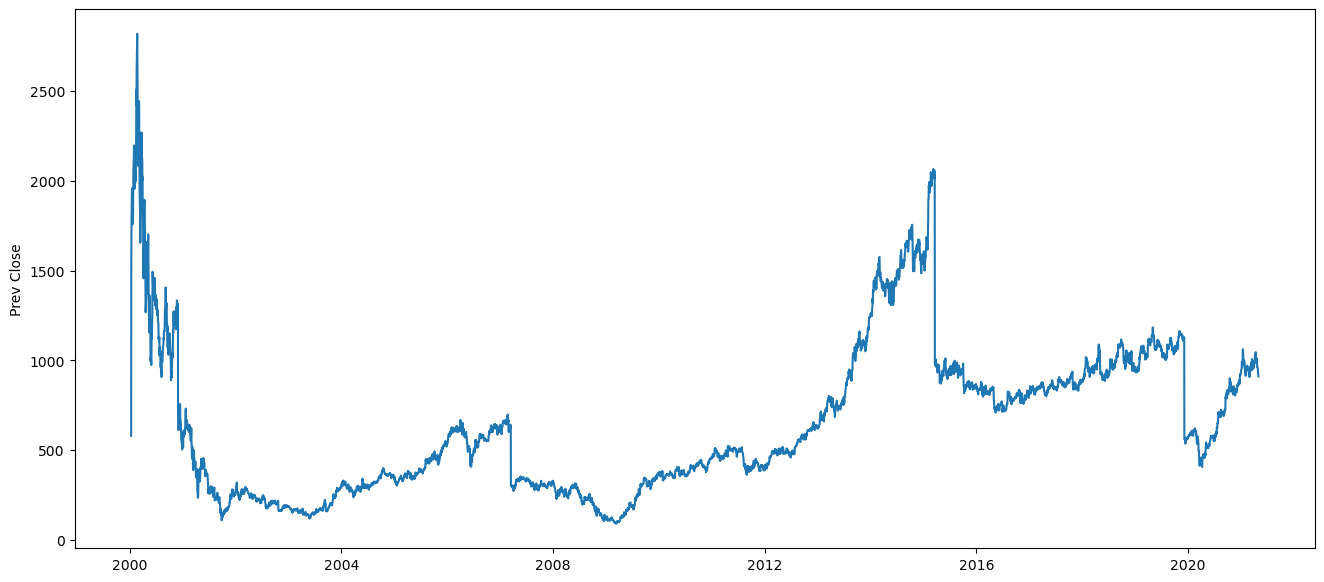

In [11]:
plt.figure(figsize=(16,7))
plt.plot(df)
plt.ylabel('Prev Close')

In [12]:
df = df['2013-01-01':'2013-12-2']

In [13]:
df

,Prev Close
Date,
2013-01-01,618.70
2013-01-02,622.15
2013-01-03,625.25
2013-01-04,625.95
2013-01-07,634.05
...,...
2013-11-26,1053.00
2013-11-27,1059.75
2013-11-28,1058.55


In [14]:
df.describe()

,Prev Close
count,230.000000
mean,852.953478
std,156.484472
min,618.700000
25%,736.350000
50%,777.450000
75%,1023.962500
max,1161.150000


## Data Exploration

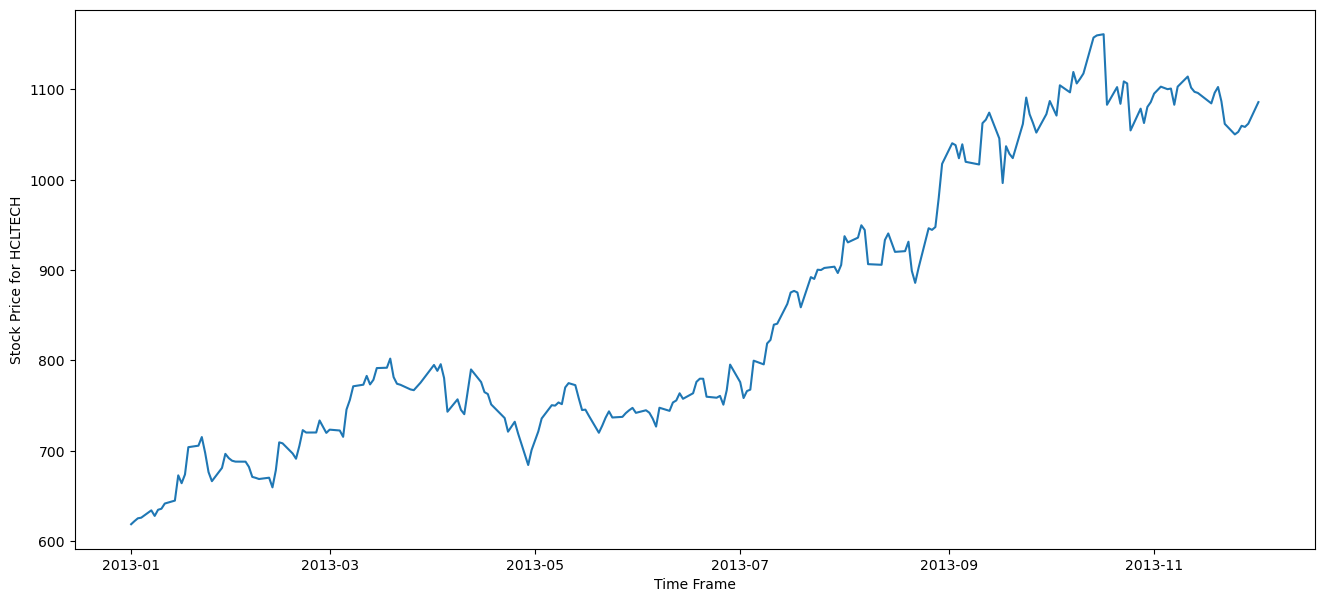

In [15]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Time Frame')
ax1.set_ylabel('Stock Price for HCLTECH')
ax1.plot(df)
plt.show()

* We see trend
* But we don't see seasonaly component

## Check Stationarity

* Method 1 - Rolling Statistics
* Method 2 - Duckey Fuller

In [16]:
# Determing rolling statistics
rollmean = df.rolling(12).mean()
rollstd = df.rolling(12).std()

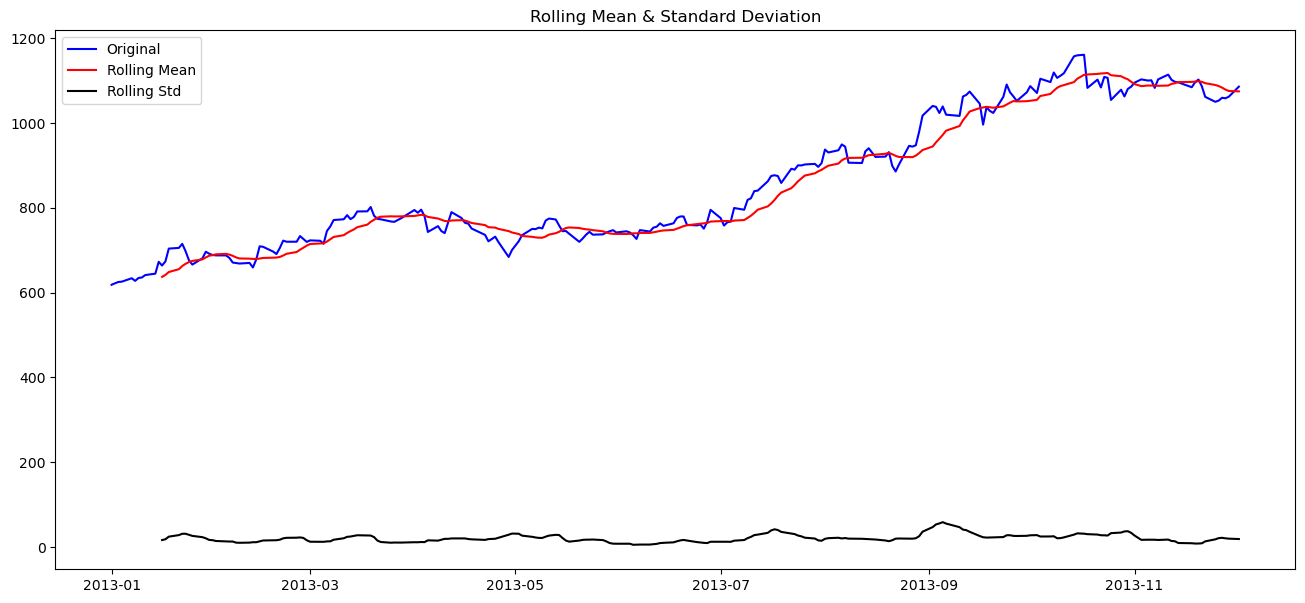

In [17]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)

# Plot rolling statistics
orig = plt.plot(df, color='blue', label='Original')
mean = plt.plot(rollmean, color='red', label='Rolling Mean')
std = plt.plot(rollstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

* Rolling Mean is not constant
* Rolling Std is more or less constant in time

So the Time Series is not stationary

## Making Series Stationary

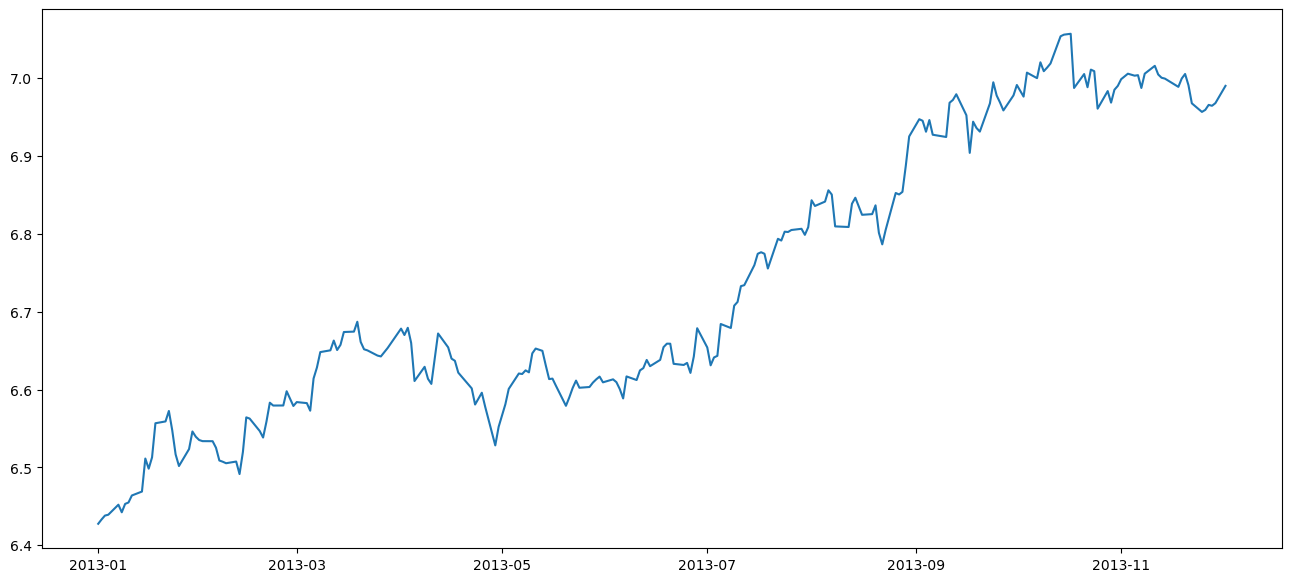

In [18]:
# Let's try transformation
plt.figure(figsize=(16,7))
fig = plt.figure(1)

ts_log = np.log(df)
plt.plot(ts_log)

After log transformation the Time Series haven't become stationary

To doble-check this let's decompose the Time Series into seasonal components

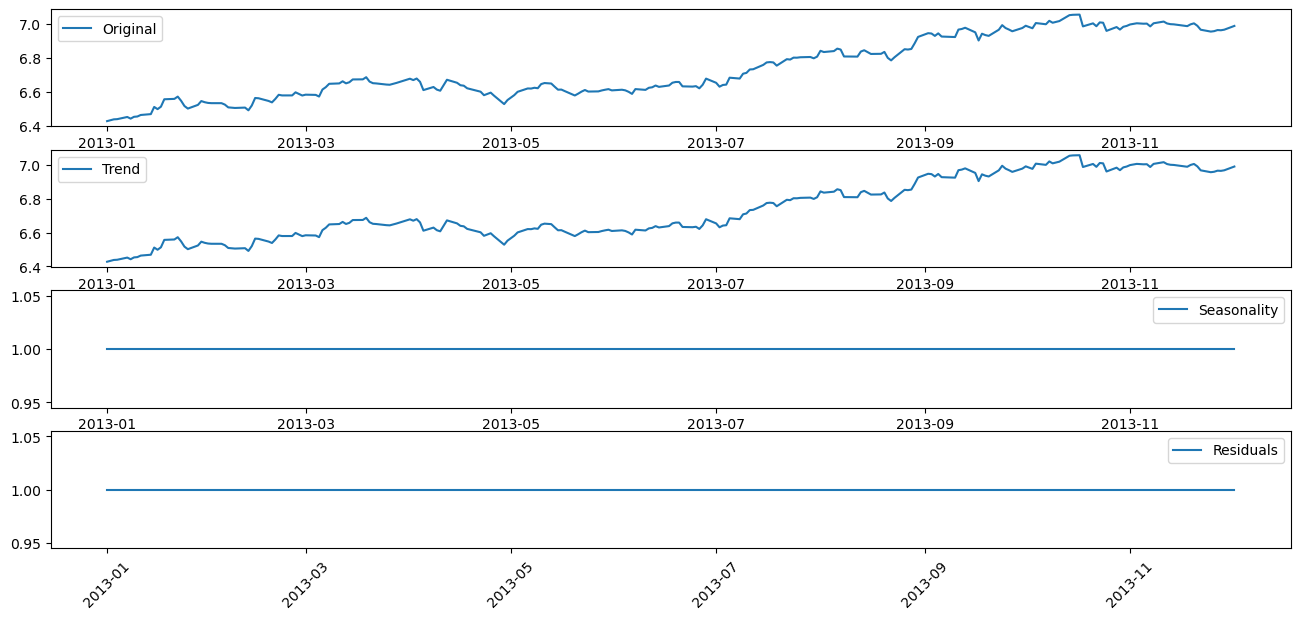

In [19]:
# Decomposition Like in Example
decomposition = seasonal_decompose(ts_log,
                                   period=1,
                                   model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,7))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')


plt.xticks(rotation=45)
plt.show()

<Figure size 2000x700 with 0 Axes>

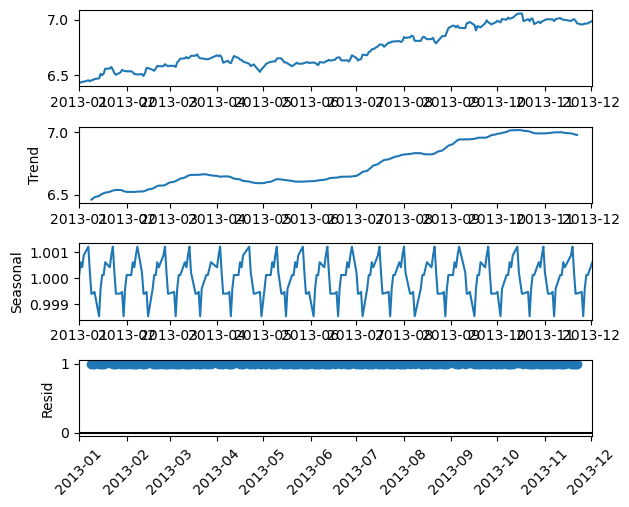

In [20]:
# Decomposition with Period = 12
decomposition = seasonal_decompose(ts_log,
                                   period=12,
                                   model='multiplicative')

plt.figure(figsize=(20,7))
fig = decomposition.plot()
plt.xticks(rotation=45)
plt.show()

* After decopmosition with period=1 only the Trend component is contributing to the time series
* After decopmosition with period=12 there are both Trend and Seasonal components

## Differencing

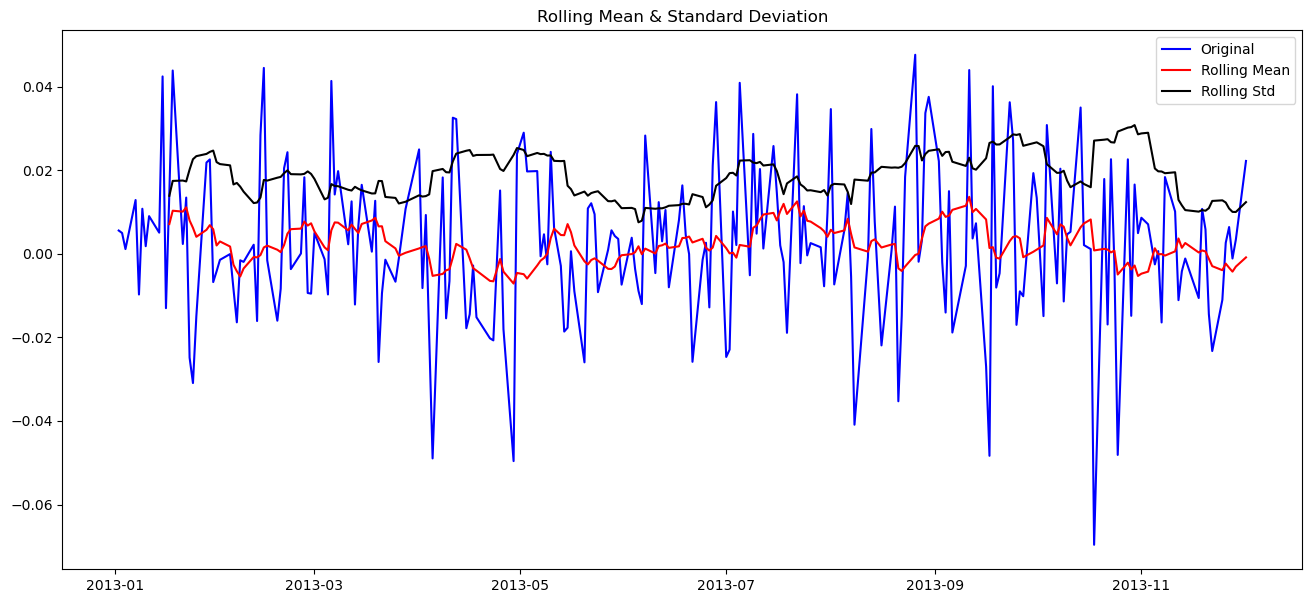

In [21]:
# Shift by 1 and subtract
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log_diff = ts_log - ts_log.shift(1)

# Determine rolling statistics
rollmean = ts_log_diff.rolling(12).mean()
rollstd = ts_log_diff.rolling(12).std()

# Plot rolling statistics
orig = plt.plot(ts_log_diff, color='blue', label='Original')
mean = plt.plot(rollmean, color='red', label='Rolling Mean')
std = plt.plot(rollstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

* Mean is constant
* Std is constant
* Time Series is <b>stationary after log and difference transformation</b>

## ACF and PACF

* ACF and PACF determines what will be the order of your AR component MA component in ARIMA model

In [22]:
ts_log_diff = ts_log_diff.sort_index()

In [23]:
ts_log_diff = ts_log_diff.dropna()

In [24]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20)

In [25]:
lag_acf, lag_pacf

(array([ 1.        ,  0.01170298, -0.11711395, -0.05834864, -0.00812335,
        -0.01355435, -0.08199592,  0.07006945,  0.09627844, -0.05439723,
        -0.19320475,  0.0288428 ,  0.04914072,  0.00378679, -0.03228466,
         0.05337855, -0.01209767, -0.01578869,  0.00640928,  0.0802487 ,
         0.00347923]),
 array([ 1.        ,  0.01175431, -0.1183003 , -0.05698489, -0.02147984,
        -0.02787291, -0.09261433,  0.06794047,  0.07734802, -0.05425234,
        -0.18284014,  0.03206431,  0.00371098, -0.0017364 , -0.02922841,
         0.04106507, -0.05288586,  0.02915944,  0.03490342,  0.0655026 ,
        -0.04036058]))

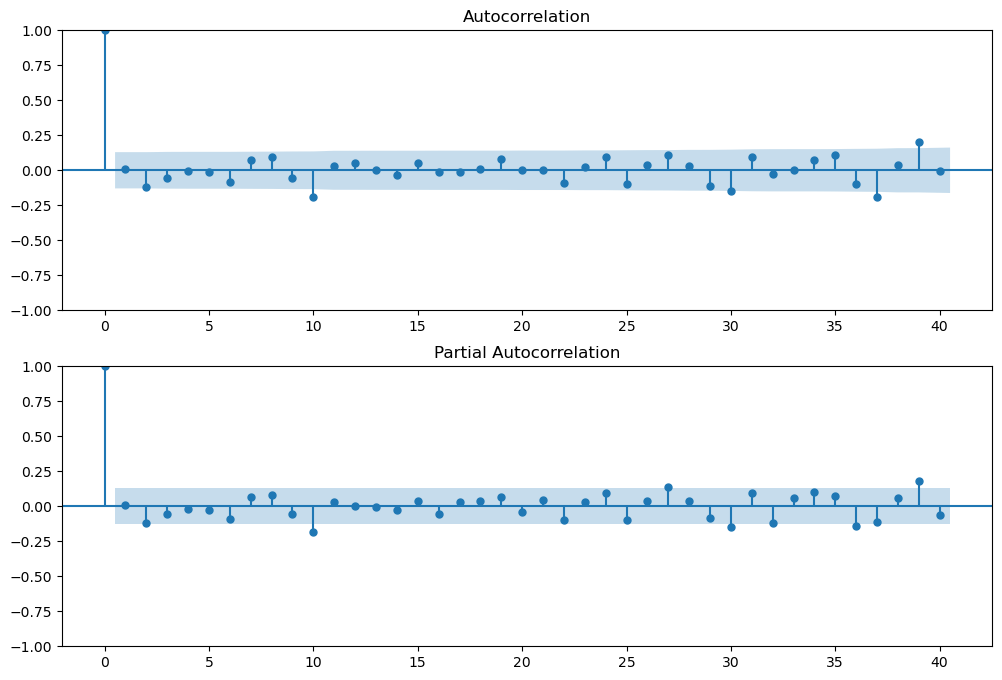

In [26]:
# Plot ACF chart and PACF chart
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.dropna(),
                               lags=40,
                               ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff.dropna(),
                                lags=40,
                                ax=ax2)

* These charts will help to understand what values of AR, MA and I are good for your ARIMA model
* Highlited areas are confidence intervals
* The first line that crosses the confidence interval - is the best order
* Here the line 2 is on the border of confidence interval
* Consider AR = 2 (from Autocorrelation ACF)
* Consider MA = 2 (from Partial Autocorrelation PACF)
* Start d = 0

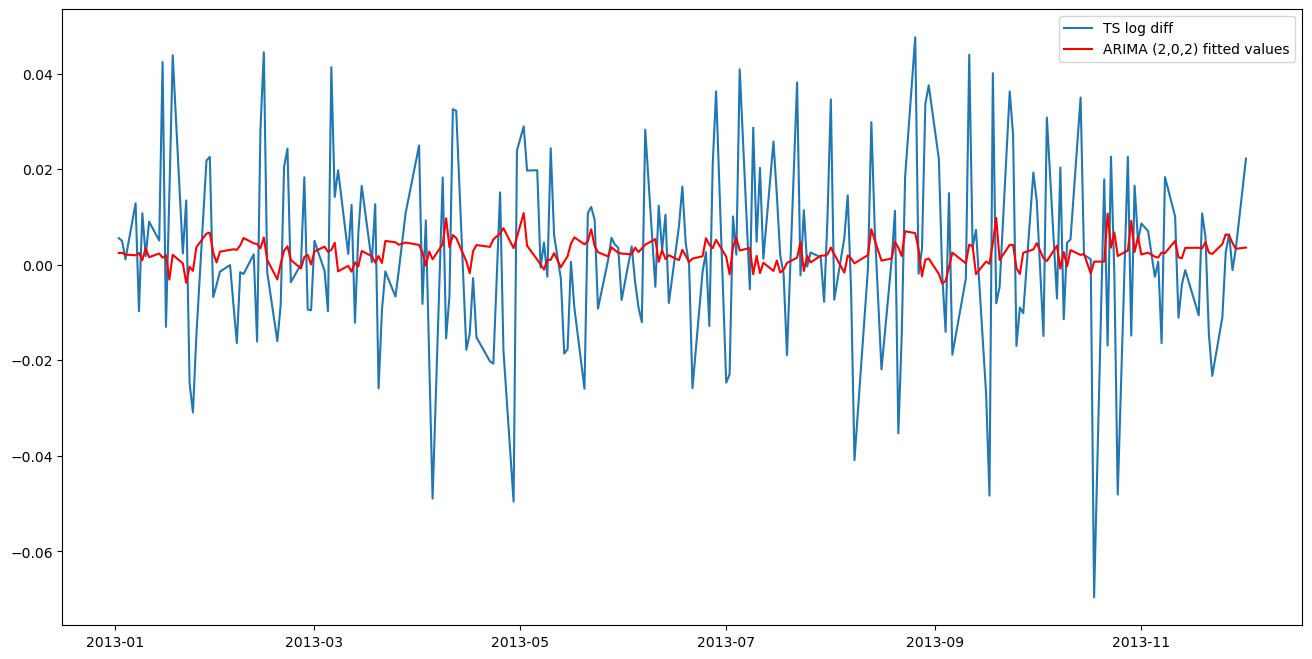

In [27]:
plt.figure(figsize=(16,8))
model = ARIMA(ts_log_diff, order=(2,0,2))
model_fit = model.fit()

plt.plot(ts_log_diff, label='TS log diff')
plt.plot(model_fit.fittedvalues, color='red', label='ARIMA (2,0,2) fitted values')
plt.legend(loc='best')
plt.show()

## Taking results back to original scale

In [28]:
ARIMA_diff_pred = pd.Series(model_fit.fittedvalues, copy=True)

In [29]:
ARIMA_diff_pred.head()

Date
2013-01-02    0.002435
2013-01-03    0.002482
2013-01-04    0.002108
2013-01-07    0.001973
2013-01-08    0.002456
dtype: float64

In [30]:
# cumsum is oposit to difference
ARIMA_diff_pred_cumsum = ARIMA_diff_pred.cumsum()

In [31]:
ARIMA_diff_pred_cumsum.head()

Date
2013-01-02    0.002435
2013-01-03    0.004917
2013-01-04    0.007024
2013-01-07    0.008998
2013-01-08    0.011453
dtype: float64

In [32]:
ARIMA_log_pred = pd.Series(ts_log.iloc[0][0], index=ts_log.index)
ARIMA_log_pred = ARIMA_log_pred.add(ARIMA_diff_pred_cumsum, fill_value=0)

In [33]:
ARIMA_log_pred.head()

Date
2013-01-01    6.427621
2013-01-02    6.430055
2013-01-03    6.432537
2013-01-04    6.434645
2013-01-07    6.436618
dtype: float64

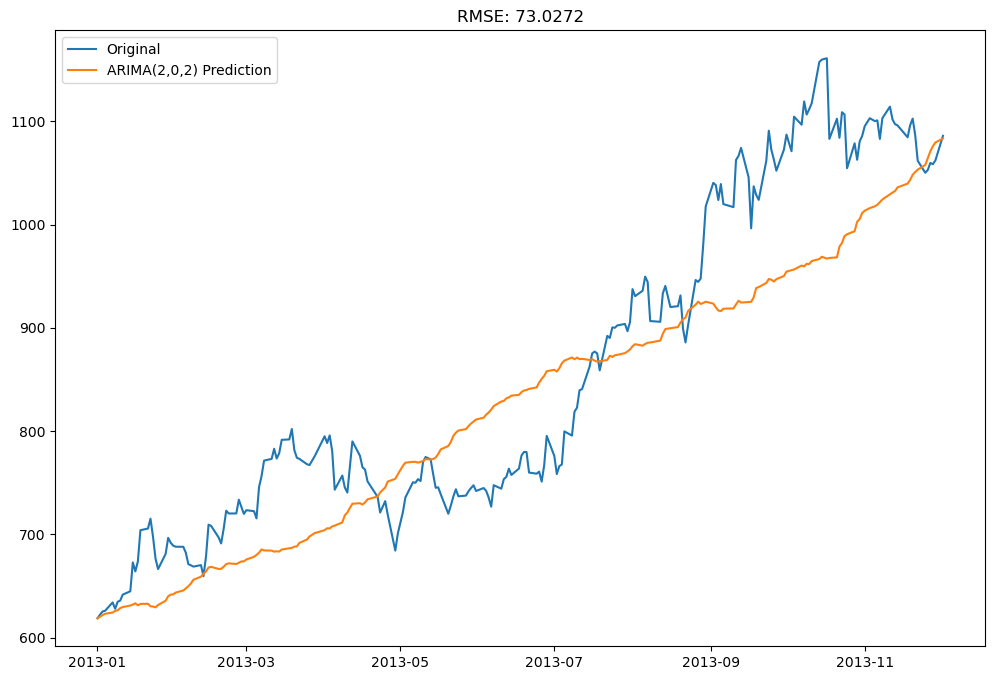

In [34]:
plt.figure(figsize=(12,8))
pred_ARIMA = np.exp(ARIMA_log_pred)
plt.plot(df["Prev Close"], label='Original')
plt.plot(pred_ARIMA, label='ARIMA(2,0,2) Prediction')
plt.title(f'RMSE: {np.sqrt(sum((pred_ARIMA - df["Prev Close"])**2)/len(df["Prev Close"])):.6}')
plt.legend(loc='best')
plt.show()

* This model captures <b>Trend</b> component very well
* But doesn't capture unexpected ups and downs

In [35]:
model_fit.predict(10,20)

Date
2013-01-16    0.001990
2013-01-17   -0.003102
2013-01-18    0.002076
2013-01-21    0.000278
2013-01-22   -0.003800
2013-01-23   -0.000428
2013-01-24   -0.001295
2013-01-25    0.003642
2013-01-28    0.006516
2013-01-29    0.006710
2013-01-30    0.002534
Name: predicted_mean, dtype: float64

# Some Experiments

In [41]:
def arima_train_and_predict(p,d,q):
    model = ARIMA(ts_log_diff, order=(p,d,q))
    model_fit = model.fit()
    ARIMA_diff_pred = pd.Series(model_fit.fittedvalues, copy=True)
    ARIMA_diff_pred_cumsum = ARIMA_diff_pred.cumsum()
    ARIMA_log_pred = pd.Series(ts_log.iloc[0][0], index=ts_log.index)
    ARIMA_log_pred = ARIMA_log_pred.add(ARIMA_diff_pred_cumsum, fill_value=0)
    
    plt.figure(figsize=(12,8))
    pred_ARIMA = np.exp(ARIMA_log_pred)
    plt.plot(df["Prev Close"], label='Original')
    label_pred = f'ARIMA({p},{d},{q}) Prediction'
    plt.plot(pred_ARIMA, label=label_pred)
    plt.title(f'RMSE: {np.sqrt(sum((pred_ARIMA - df["Prev Close"])**2)/len(df["Prev Close"])):.6}')
    plt.legend(loc='best')
    plt.show()
    
    return model_fit

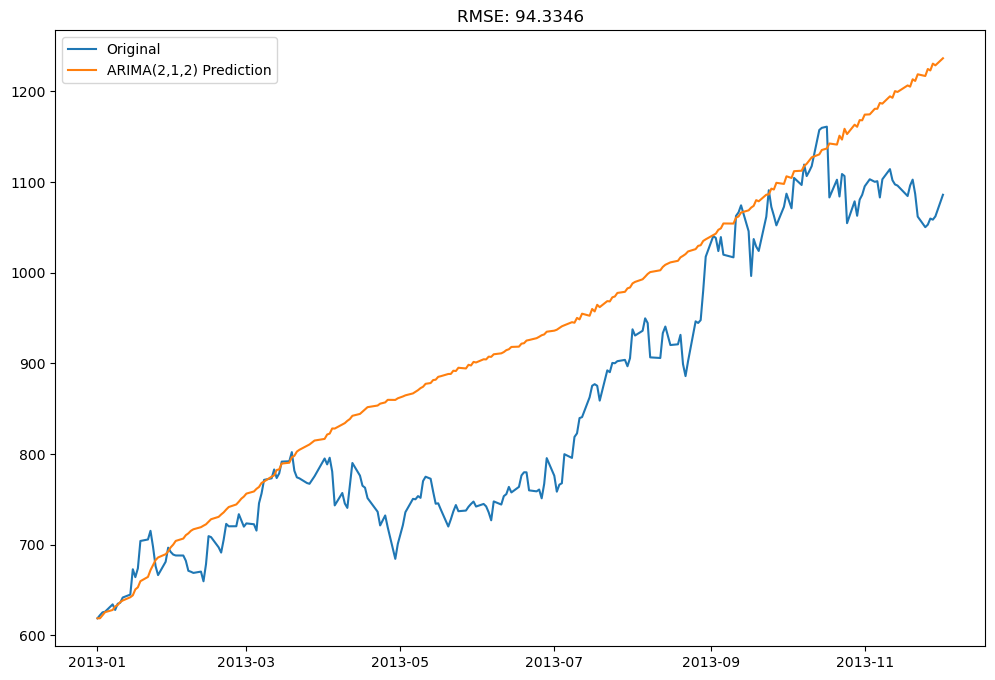

In [42]:
arima_train_and_predict(2,1,2)

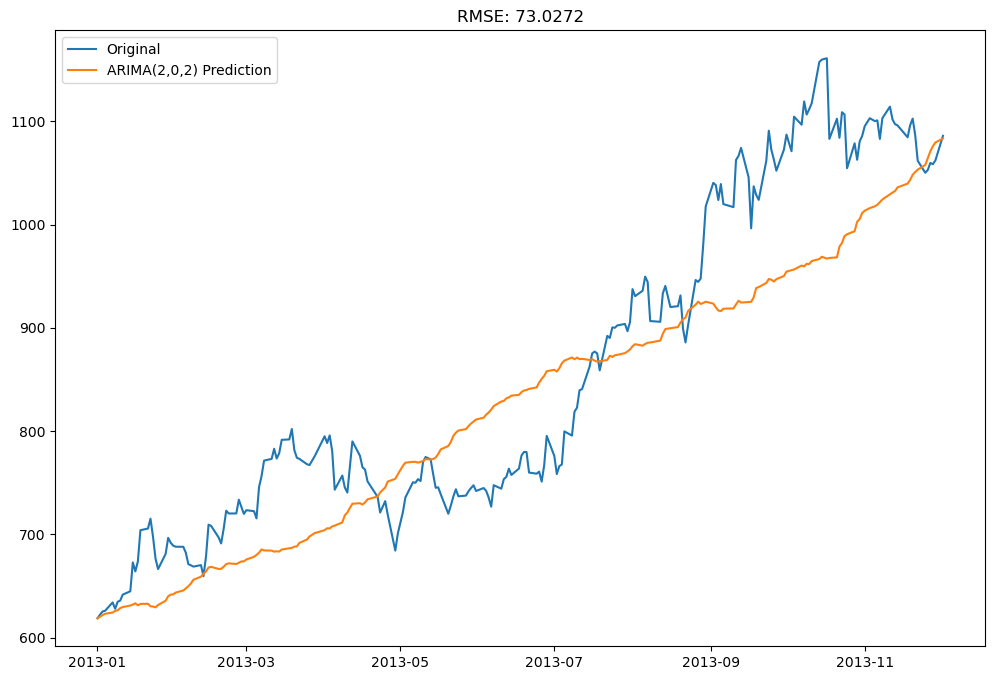

In [43]:
arima_train_and_predict(2,0,2)

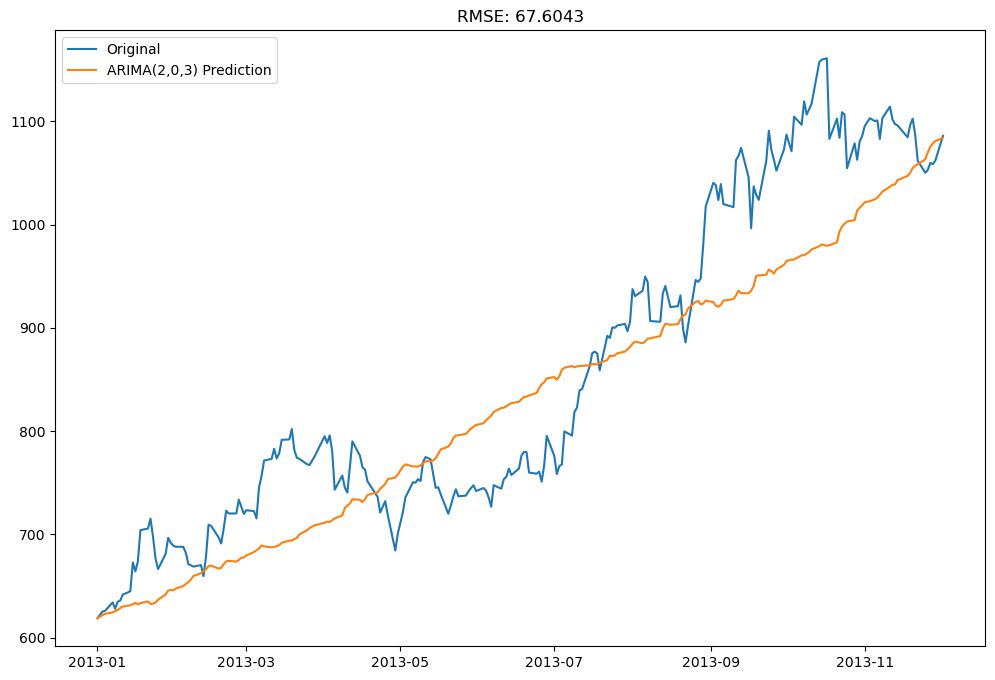

In [44]:
arima_train_and_predict(2,0,3)

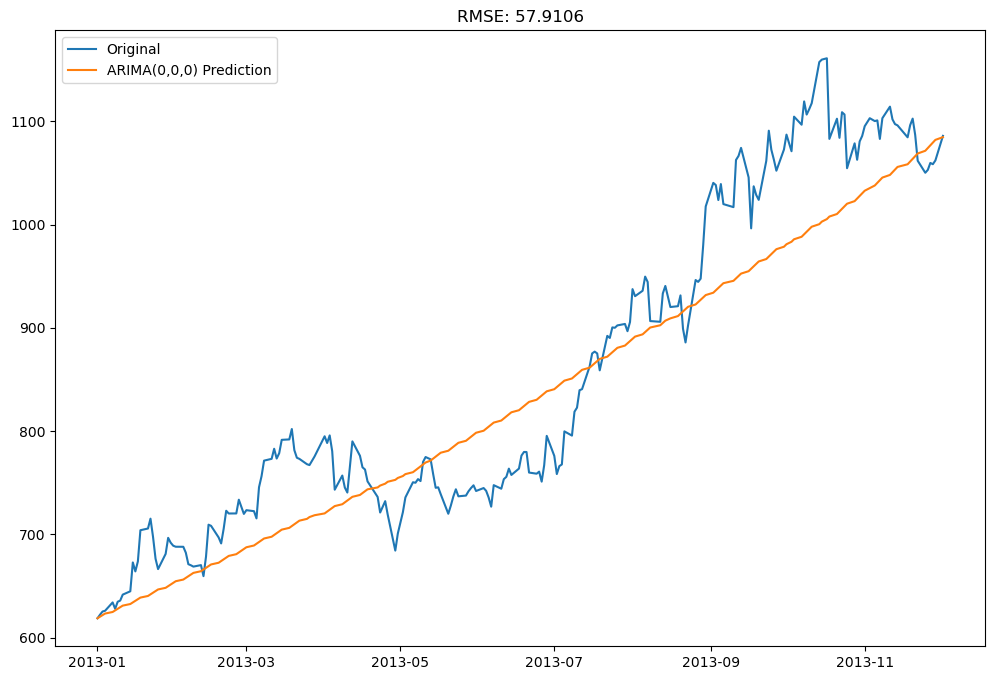

In [45]:
arima_train_and_predict(0,0,0)

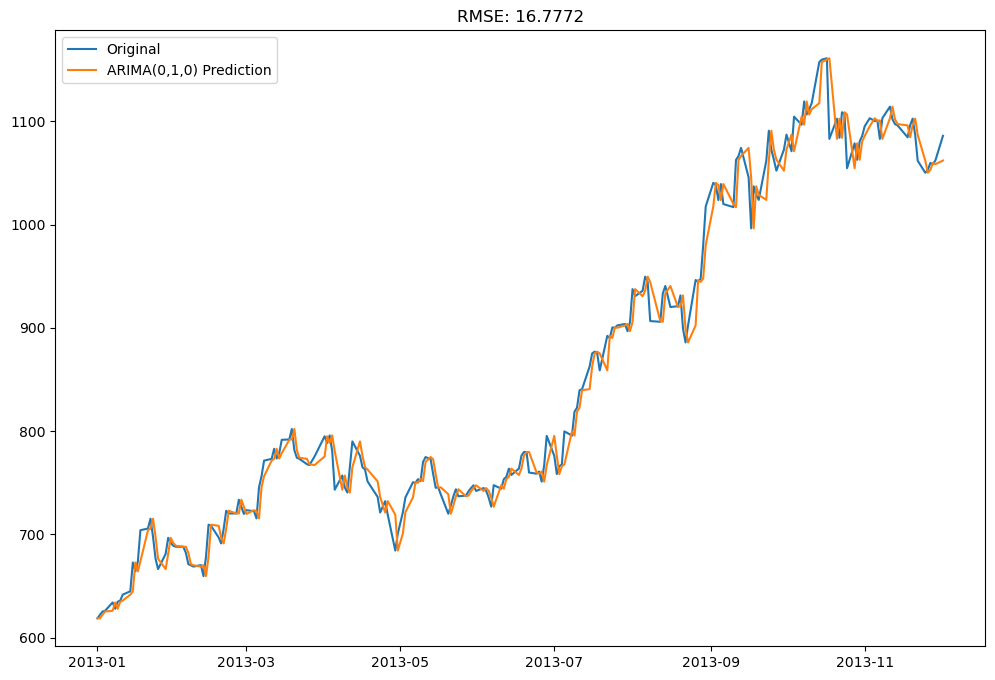

In [46]:
model_ft = arima_train_and_predict(0,1,0)

In [47]:
model_ft.predict(30)

Date
2013-02-13   -0.016094
2013-02-14    0.028403
2013-02-15    0.044465
2013-02-18   -0.001552
2013-02-19   -0.016012
                ...   
2013-11-26   -0.011032
2013-11-27    0.002615
2013-11-28    0.006390
2013-11-29   -0.001133
2013-12-02    0.003395
Name: predicted_mean, Length: 199, dtype: float64

In [48]:
model_ft.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Prev Close   No. Observations:                  229
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 505.266
Date:                Mon, 14 Aug 2023   AIC                          -1008.531
Time:                        10:56:22   BIC                          -1005.102
Sample:                             0   HQIC                         -1007.147
                                - 229                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0007   5.72e-05     12.178      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  43.43   Jarque-Bera (JB):                 7.22
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               1.75   Skew:                             0.32
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""